In [1]:
%reset -f
import sys; sys.path.append('../code')

import matplotlib.pyplot as plt
plt.rcParams['font.serif'] = ['Times'] + plt.rcParams['font.serif']

plt.rcParams['text.usetex'] = False
#plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams["ps.usedistiller"] = 'xpdf'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams["mathtext.fontset"] = 'cm'

from plot_utility import mathify_ticklabels

C:\Users\bcellini\Anaconda3\envs\wind-sense\lib\site-packages\flyplotlib-0.0.1-py3.9.egg\fly_plot_lib\plot.py:972: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\bcellini\Anaconda3\envs\wind-sense\lib\site-packages\flyplotlib-0.0.1-py3.9.egg\fly_plot_lib\plot.py:1026: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\bcellini\Anaconda3\envs\wind-sense\lib\site-packages\flyplotlib-0.0.1-py3.9.egg\fly_plot_lib\plot.py:972: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\bcellini\Anaconda3\envs\wind-sense\lib\site-packages\flyplotlib-0.0.1-py3.9.egg\fly_plot_lib\plot.py:1026: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\bcellini\Anaconda3\envs\wind-sense\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\bcellini\Anaconda3\en

In [2]:
# import run_analysis_180 as run_analysis
import run_analysis as run_analysis
import direct_trajectory_simulator
import matplotlib.pyplot as plt
import utility
import numpy as np
import figurefirst as fifi
import fly_plot_lib.flymath as flymath
import pynumdiff
import pandas
import os
import matplotlib
import fly_plot_lib.plot as fpl

import scipy.interpolate
interp2d = scipy.interpolate.interp2d

import utility

In [3]:
from plot_utility import plot_timeseries, plot_ground_speed, plot_sensor_data
from plot_utility import plot_example_zeta_timeseries, get_filenames_sorted_by_tau_and_T, load_real_wind
from plot_utility import plot_errors, colorbar, get_error_heatmap_for_Tmultiplier, plot_error_heatmap

In [4]:
import matplotlib
print('matplotlib version: ', matplotlib.__version__)
print('numpy version: ', np.__version__)

matplotlib version:  3.5.1
numpy version:  1.23.1


In [5]:
fififig = '../grant/constant_gamma_vs_psi.svg'
FONTSIZE = 7

# Plot trajectory

In [14]:
psi_freq = 0.1 # turning frequency
smoothness_weight = 1 # how smooth
turn_amplitude = '180deg' # 20deg, 90deg, or 180deg
phi_alignment = 'align_psi' # align_gamma or align_psi
L = 2000 # number of data points

t = np.linspace(0, 5, L)
zeta = np.sin(t*2)
w = np.ones_like(zeta)*2

df, bmp = run_analysis.get_df_random( wind=[zeta,w], # manually code wind, or 'realdynamic' or 'realconstant'
                   L=L, 
                   psi_freq=psi_freq,
                   dt=0.1,
                   t=None,
                   turn_amplitude=turn_amplitude,
                   smoothness_weight=smoothness_weight,
                   angular_noise_std=0,
                   velocity_profile='constant', # 'constant' or 'absine'
                   phi=phi_alignment,
                   of_noise_std=0,
                   air_noise_std=0,
                   random_seed=7)

# print(df)

Number of turns per sec:  0.19509754877438718


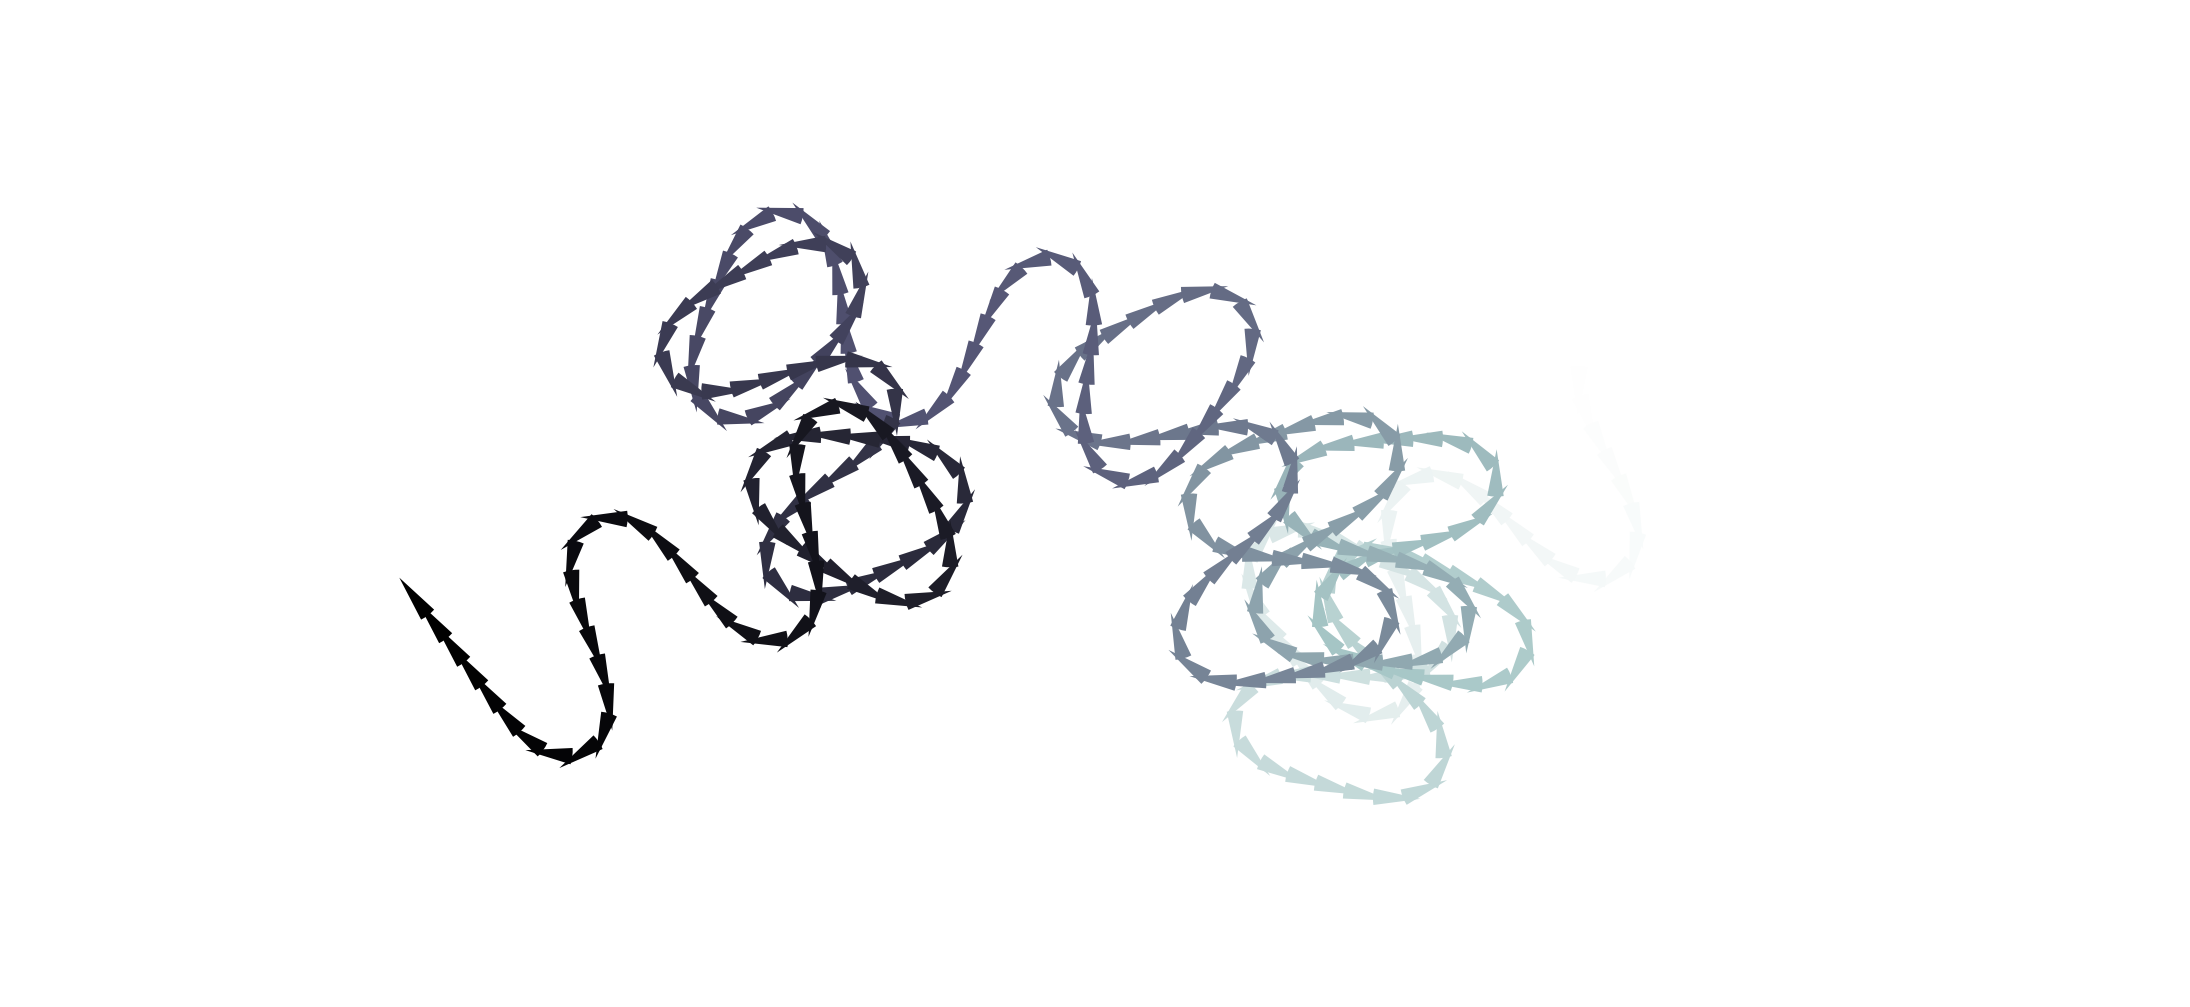

In [16]:
fig = plt.figure(figsize=(3.5,2), dpi=600)
ax = fig.add_subplot(111)
direct_trajectory_simulator.plot_trajec(df, ax=ax, size_radius=0.8, nskip = 5, 
                                        show_wind_quivers=False)


In [10]:
dt = np.mean(np.diff(df.t))
turn_period = (1/psi_freq / 2)
correction_window_for_2pi = int(turn_period/2./dt)

In [11]:
df_sensor, parameters = utility.get_sensor_measurements_derivatives_controls(df, 
                                                             derivative_method='smooth_finite_difference.butterdiff', 
                                                             params='turning',
                                                             angular_noise_std=0,
                                                             sensor_group='polar',
                                                             return_smoothed=False,
                                                             cutoff_freq=psi_freq*2,
                                                             phi_alignment=phi_alignment,
                                                             correction_window_for_2pi=correction_window_for_2pi,
                                                            )

Automatically determine params based on 1x turning frequency
Smoothing parameters
Turning freq: 0.2
Butter freq: 0.04
Params gamma, psi, phi: 
[4, 0.04]
[4, 0.04]
[4, 0.04]


In [12]:
start_ix = 0
df_sensor = df_sensor[start_ix:]

In [13]:
gamma = df_sensor.sensor_gamma_smooth
psi = df_sensor.sensor_psi_smooth
phi = df_sensor.sensor_phi_smooth

In [14]:
gamma_dot = df_sensor.sensor_gamma_dot
psi_dot = df_sensor.sensor_psi_dot
phi_dot = df_sensor.sensor_phi_dot

In [15]:
delta = gamma - psi
delta_dot = gamma_dot - psi_dot

In [16]:
inside_sqrt = delta_dot**2 + np.tan(delta)**2*(gamma_dot**2+2*gamma_dot*phi_dot+phi_dot**2)
inside_arctan = (delta_dot - np.sqrt(inside_sqrt)) / (gamma_dot+phi_dot*np.tan(delta))
zeta_pi = (2*np.arctan(inside_arctan) + phi + gamma).values
zeta_pi = utility.wrap_angle(zeta_pi)

In [17]:
alpha = utility.wrap_angle(gamma + phi)
sign_agreement = np.sign( np.sin(delta) ) - np.sign( np.sin(alpha-zeta_pi))
zeta_pi[np.where(sign_agreement!=0)] = zeta_pi[np.where(sign_agreement!=0)] + np.pi
zeta_pi = utility.wrap_angle(zeta_pi)

In [18]:
t = df_sensor.t.values

In [19]:
zeta_smooth, zeta_dot = utility.diff_angle(zeta_pi, dt, [2, 0.004])

Text(0, 0.5, 'Wind direction')

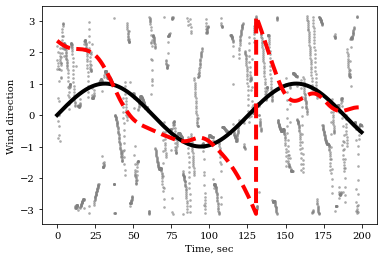

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t, zeta_pi, '.', color='gray', markersize=3.5, alpha=0.5)
ax.plot(t, df.zeta[start_ix:], '-', color='black', linewidth=4)
ax.plot(t, zeta_smooth, '--', color='red', linewidth=4)

ax.set_xlabel('Time, sec')
ax.set_ylabel('Wind direction')

In [21]:
if 0: # nicer plots for floris
    layout = fifi.svg_to_axes.FigureLayout(fififig, 
                                           autogenlayers=True, make_mplfigures=True, hide_layers=[])

    ax = layout.axes[(phi_alignment, 'trajec')]
    direct_trajectory_simulator.plot_trajec(df, ax=ax, size_radius=0.8, nskip = 5, 
                                            show_wind_quivers=False)

    ax = layout.axes[(phi_alignment, 'estimate')]
    ax.plot(t, df.zeta[start_ix:], '-', color='black', linewidth=4)
    ax.plot(t, zeta_pi, '.', markerfacecolor='red', markeredgecolor='none', markersize=2, alpha=0.5, rasterized=True)
    ax.plot(t, zeta_smooth, '--', color='red', linewidth=4)


    ax.set_xlim(0, 200)
    ax.set_ylim(-np.pi, np.pi)
    yticks = [-np.pi, 0, np.pi]
    xticks = [0, 100, 200]
    fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                         yticks=yticks,
                                         xticks=xticks,
                                         tick_length=2.5,
                                         spine_locations={'right': 4},
                                         linewidth=0.5)

    ax.set_ylabel('Wind direction', labelpad=-5)
    ax.set_yticklabels(['$-\pi$', '$0$', '$\pi$'])
    ax.set_xlabel('Time, sec')

    fifi.mpl_functions.set_fontsize(ax, FONTSIZE)

    layout.append_figure_to_layer(layout.figures[phi_alignment], phi_alignment, cleartarget=True)
    layout.write_svg(fififig)

# Using a difference derivative

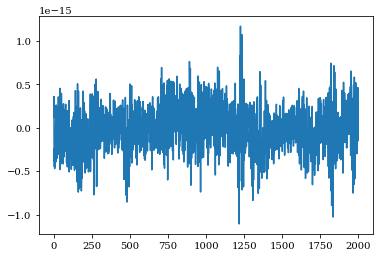

In [116]:
plt.plot(df.gamma)

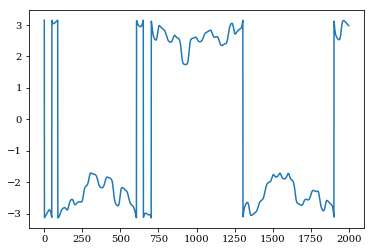

In [117]:
plt.plot(df.phi)

In [118]:
delay = 150
dt = np.mean(np.diff(df.t))
dT = delay*dt

gamma_dot = utility.wrap_angle(df.gamma.values[delay:] - df.gamma.values[0:-delay]) #/ (dT)
psi_dot = utility.wrap_angle(df.psi.values[delay:] - df.psi.values[0:-delay]) #/ (dT)
phi_dot = utility.wrap_angle(df.phi.values[delay:] - df.phi.values[0:-delay]) #/ (dT)

In [119]:
gamma = np.vstack([df.gamma.values[delay:], df.gamma.values[0:-delay]])
gamma = [utility.mean_angle(gamma[:, i]) for i in range(gamma.shape[1])]
gamma = np.array(gamma)

psi = np.vstack([df.psi.values[delay:], df.psi.values[0:-delay]])
psi = [utility.mean_angle(psi[:, i]) for i in range(psi.shape[1])]
psi = np.array(psi)

phi = np.vstack([df.phi.values[delay:], df.phi.values[0:-delay]])
phi = [utility.mean_angle(phi[:, i]) for i in range(phi.shape[1])]
phi = np.array(phi)


In [120]:
delta = gamma - psi
delta_dot = gamma_dot - psi_dot

In [121]:
inside_sqrt = delta_dot**2 + np.tan(delta)**2*(gamma_dot**2+2*gamma_dot*phi_dot+phi_dot**2)
inside_arctan = (delta_dot - np.sqrt(inside_sqrt)) / (gamma_dot+phi_dot*np.tan(delta))
zeta_pi = 2*np.arctan(inside_arctan) + phi + gamma
zeta_pi = utility.wrap_angle(zeta_pi)

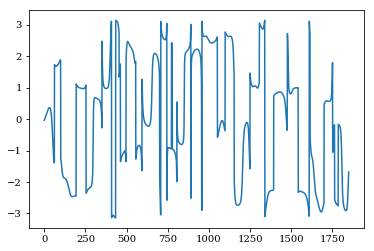

In [122]:
plt.plot(zeta_pi)

In [123]:
alpha = gamma + phi
sign_agreement = np.sign( np.sin(delta) ) - np.sign( np.sin(alpha-zeta_pi))
zeta_pi[np.where(sign_agreement!=0)] = zeta_pi[np.where(sign_agreement!=0)] + np.pi

In [124]:
zeta_pi = utility.wrap_angle(zeta_pi)

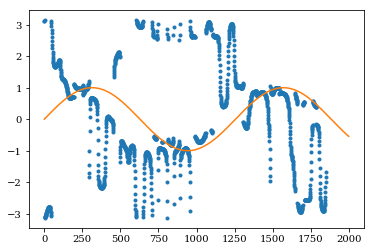

In [125]:
plt.plot(zeta_pi, '.')
plt.plot(df.zeta)